In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [273]:
df = pd.read_csv('clean.csv',parse_dates=['date'])
df.head()

,Unnamed: 0,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name
0,0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,ahmadnagar
1,1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01,ahmadnagar
2,2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01,ahmadnagar
3,3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01,ahmadnagar
4,4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01,ahmadnagar


In [274]:
df.drop(['Unnamed: 0','district_name'],axis=1,inplace=True)
df.head()


,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01
1,ahmednagar,bajri,2016,april,106.0,1788.0,1925.0,1875.0,2016-04-01
2,ahmednagar,wheat(husked),2015,april,1253.0,1572.0,1890.0,1731.0,2015-04-01
3,ahmednagar,wheat(husked),2016,april,387.0,1750.0,2220.0,1999.0,2016-04-01
4,ahmednagar,sorgum(jawar),2015,april,3825.0,1600.0,2200.0,1900.0,2015-04-01


### First, we will get the trendline by finding mean of all the commodities (individually, across all APMC) for each month. 
### This can be done because any trend would change the local mean
### <font color=red> Note: Taking a leap of faith that all the APMCs suffer the same price changes due to various factors e.g. 'drought'</font>

In [275]:
trendline = pd.pivot_table(df,index='Commodity',columns=['date'],aggfunc='mean')

In [276]:
trendline['modal_price'].head()

date,2014-09-01 00:00:00,2014-10-01 00:00:00,2014-11-01 00:00:00,2014-12-01 00:00:00,2015-01-01 00:00:00,2015-02-01 00:00:00,2015-03-01 00:00:00,2015-04-01 00:00:00,2015-05-01 00:00:00,2015-06-01 00:00:00,...,2016-02-01 00:00:00,2016-03-01 00:00:00,2016-04-01 00:00:00,2016-05-01 00:00:00,2016-06-01 00:00:00,2016-07-01 00:00:00,2016-08-01 00:00:00,2016-09-01 00:00:00,2016-10-01 00:00:00,2016-11-01 00:00:00
Commodity,,,,,,,,,,,,,,,,,,,,,
amba koy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1500.000000,3750.0,4750.000000,NaN,NaN,NaN,NaN
ambat chuka,0.000000,136.000000,167.000000,270.000000,0.0,0.0,0.0,196.0,0.0,1350.0,...,0.000000,NaN,193.000000,0.000000,500.0,325.500000,919.25,665.500000,748.000000,1251.0
amla,1400.000000,1777.000000,1580.000000,1634.000000,1637.5,1800.0,1800.0,NaN,NaN,NaN,...,1275.000000,NaN,NaN,NaN,NaN,NaN,NaN,2500.000000,1700.000000,1500.0
apple,6342.666667,5922.571429,6042.833333,5164.833333,5544.0,5137.0,6233.6,8497.0,10089.0,10161.0,...,6312.333333,8293.6,9961.444444,8427.181818,10037.2,8936.181818,7276.00,7290.461538,6615.083333,6905.6
arvi,2520.500000,2397.500000,2521.000000,2266.500000,2800.0,2622.5,2313.5,2405.5,2149.0,2207.5,...,1885.000000,2135.0,2371.500000,2484.333333,2434.5,2425.000000,2267.00,2043.000000,2006.500000,2010.5


###  Example to use the trendline pivot table to get monthly trendline for any commodity
trendline['feature_name'].loc['commodity_name'].plot()

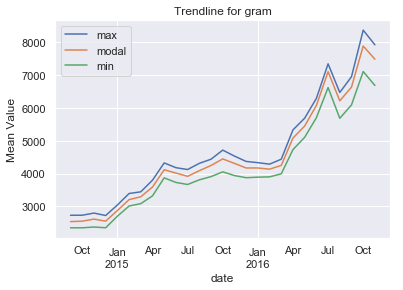

In [277]:
trendline['max_price'].loc['gram'].plot()
trendline['modal_price'].loc['gram'].plot()
trendline['min_price'].loc['gram'].plot()
plt.title('Trendline for gram')
plt.ylabel('Mean Value')
plt.legend(['max','modal','min'])

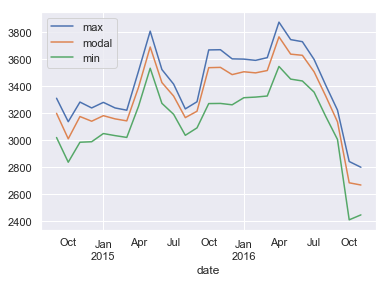

In [278]:
trendline['max_price'].loc['soybean'].plot()
trendline['modal_price'].loc['soybean'].plot()
trendline['min_price'].loc['soybean'].plot()
plt.legend(['max','modal','min'])

### The above two plots show that a generalization cannot be made about the trend for different commodity
### Mean values generated in the previous stage will be used to remove trend from the data.
### Note to self: <font color=red> Note: Subtracting the prices averaged for each month across all the APMC and subtracting the same from all the data assumes an additive behavior. </font>
### $f(t) = trend(t)+seasonal(t)+ other \,components (t)$

In [279]:
mean_data = pd.DataFrame({'modal_price':df['modal_price']})
mean_data = pd.DataFrame({'Commodity':df['Commodity']})
temp_data = pd.DataFrame({'name':np.array(trendline.index)})


In [280]:
monthly_data = df.groupby(['date', 'Commodity'])['modal_price'].mean().reset_index(name='Monthly Average')
std_data = df.groupby(['date', 'Commodity'])['modal_price'].std().reset_index(name='Monthly Std')

In [281]:
new_df = df.merge(monthly_data,on=['date','Commodity'])
new_df = new_df.merge(std_data,on=['date','Commodity'])

In [282]:
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.835821,209.379863
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.835821,209.379863
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.835821,209.379863
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.835821,209.379863
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.835821,209.379863


In [283]:
gram = new_df[new_df['Commodity']=='gram']
gram.sort_values(by='date',inplace=True)
type(gram)

C:\Users\vipul\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


pandas.core.frame.DataFrame

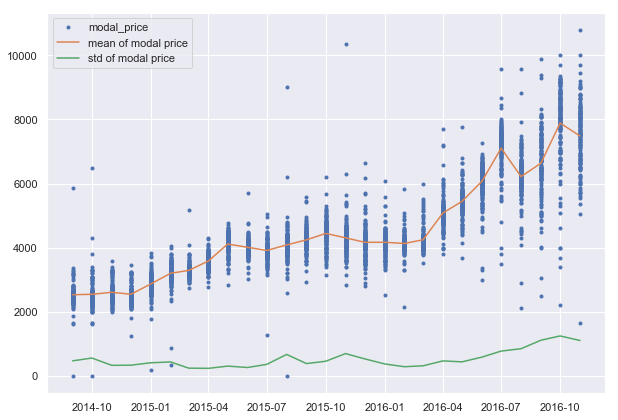

In [284]:
plt.figure(figsize=(10,7))
plt.plot(gram['date'],gram['modal_price'],'.')
plt.plot(gram['date'],gram['Monthly Average'],'-')
plt.plot(gram['date'],gram['Monthly Std'])
plt.legend(['modal_price','mean of modal price','std of modal price'])

In [285]:
new_df['fluctuation'] = new_df['modal_price']-new_df['Monthly Average']

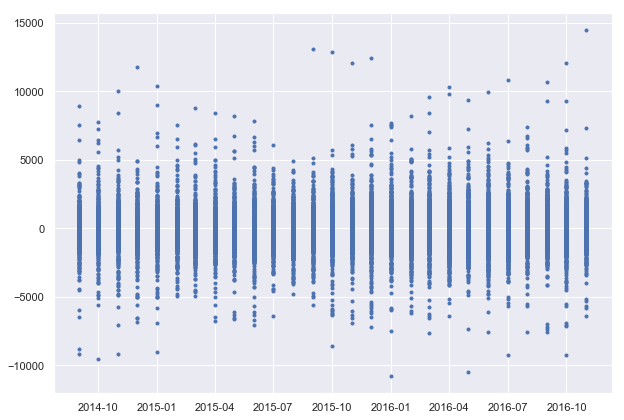

In [286]:
plt.figure(figsize=(10,7))
plt.plot(new_df['date'],new_df['fluctuation'],'.')

### The above process helped to remove the trend and have a zero mean. 
### Cross check if this is true

In [287]:
fluctuation_mean = new_df.groupby(['date', 'Commodity'])['fluctuation'].mean().reset_index(name='Fluctuation_Mean')
fluctuation_std = new_df.groupby(['date', 'Commodity'])['fluctuation'].std().reset_index(name='Fluctuation_Std')

In [288]:
new_df = new_df.merge(fluctuation_mean,on=['date','Commodity'])
new_df = new_df.merge(fluctuation_std,on=['date','Commodity'])

In [296]:
new_df.sort_values(by='date')
new_df.head()

,APMC,Commodity,Year,Month,arrivals_in_qtl,min_price,max_price,modal_price,date,Monthly Average,Monthly Std,fluctuation,Fluctuation_Mean,Fluctuation_Std
0,ahmednagar,bajri,2015,april,79.0,1406.0,1538.0,1463.0,2015-04-01,1370.835821,209.379863,92.164179,1.357455e-14,209.379863
1,akole,bajri,2015,april,52.0,1357.0,1800.0,1525.0,2015-04-01,1370.835821,209.379863,154.164179,1.357455e-14,209.379863
2,jamkhed,bajri,2015,april,164.0,1304.0,1446.0,1375.0,2015-04-01,1370.835821,209.379863,4.164179,1.357455e-14,209.379863
3,kopargaon,bajri,2015,april,354.0,1164.0,1469.0,1401.0,2015-04-01,1370.835821,209.379863,30.164179,1.357455e-14,209.379863
4,newasa,bajri,2015,april,32.0,1282.0,1293.0,1286.0,2015-04-01,1370.835821,209.379863,-84.835821,1.357455e-14,209.379863


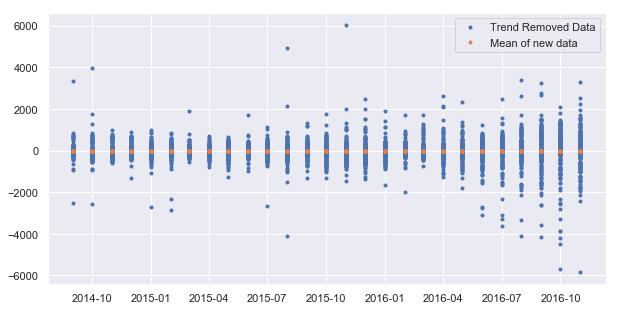

In [307]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['fluctuation'],'.')
plt.plot(gram['date'],gram['Fluctuation_Mean'],'.',linewidth=10)
plt.legend(['Trend Removed Data','Mean of new data'])

### The above plot shows that the data is scattered around zero. thus, removal of trend seems to be fine.
### Did trend removal have any effect on standard deviation? My guess says no. 

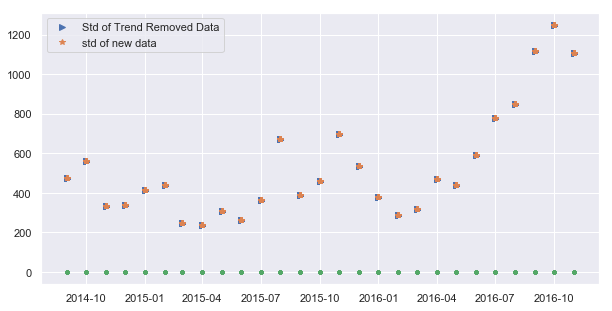

In [310]:
plt.figure(figsize=(10,5))
gram = new_df[new_df['Commodity']=='gram']
plt.plot(gram['date'],gram['Monthly Std'],'>')
plt.plot(gram['date'],gram['Fluctuation_Std'],'*',linewidth=20)
plt.plot(gram['date'],gram['Fluctuation_Mean'],'.',linewidth=10)
plt.legend(['Std of Trend Removed Data','std of new data'])